In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import linregress
import time

"""Black Scholes Analytic Solution functions adapted from John Armstrong's FMLIB library"""
def simulate_gbm_paths( S0, mu, sigma, T, n_steps, n_paths,epsilon=None):
    Z = np.zeros( [ n_paths, n_steps+1] )
    dt = T/n_steps
    Z[:,0] = np.log(S0)
    times = np.linspace(0,T,n_steps+1)
    if epsilon is None:
        epsilon = np.random.randn( n_paths, n_steps )

    for i in range(0,n_steps):
        Z[:,i+1] = Z[:,i] + (mu-0.5*sigma**2) * dt + sigma*np.sqrt(dt)*epsilon[:,i]

    S = np.exp(Z)
    return S, times

def Ncdf(x):
    return scipy.stats.norm.cdf(x)

def compute_d1_and_d2( S, t, K, T, r, sigma):
    tau = T-t
    d1 = 1/(sigma*np.sqrt(tau))*(np.log(S/K) + (r+0.5*sigma**2)*tau)
    d2 = d1 - sigma*np.sqrt(tau)
    return d1,d2

def black_scholes_call_price(S, t, K, T, r, sigma):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,sigma)
    return S*Ncdf(d1) - np.exp(-r*(T-t))*K*Ncdf(d2)

def black_scholes_put_price(S, t, K, T, r, sigma):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,sigma)
    return -S*Ncdf(-d1) + np.exp(-r*(T-t))*K*Ncdf(-d2)

def black_scholes_delta(S,t,K,T,r,sigma):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,sigma)
    return Ncdf(d1)

def black_scholes_put_delta(S,t,K,T,r,sigma):
    d1, d2 = compute_d1_and_d2(S,t,K,T,r,sigma)
    return Ncdf(d1)-1

In [3]:
"""Functions implementing Monte Carlo techniques for problem"""

def sigma(t):
    #implementation of deterministic volatility function
    if t<0.6:
        return 0.12+0.14*(t/0.6)
    else:
        return 0.26


def simulate_SDE_paths( S0, mu, gamma, T, n_steps, n_paths,epsilon=None):
    #euler scheme approximation, outputs a path for the question SDE
    if epsilon is None:
        epsilon = np.random.randn( n_paths, n_steps )

    S = np.zeros( [ n_paths, n_steps+1] )
    dt = T/n_steps
    S[:,0] = S0
    times = np.linspace(0,T,n_steps+1)

    for i in range(0,n_steps):
        S[:,i+1] = S[:,i] + S[:,i] * mu * dt + (S[:,i] ** gamma) * sigma(times[i]) * np.sqrt(dt) * epsilon[:,i]
        
    return S, times

def payoff(CP,S_T,K):
    #evaluates payoff in specific scenario. CP variable is "C" for a Call, "P" for a Put
    values = np.ones(S_T.shape)*K

    if CP == "P":
        values= np.maximum(values - S_T,0)

    if CP == "C":
        values= np.maximum(S_T - values,0)

    return values

def MC_samples(S0,r,mu,gamma,T,n_steps,n_paths,CP,K,epsilon=None):
    #outputs naive monte carlo payoff scenarios
    if epsilon is None:
        option_eps = np.random.randn( n_paths, n_steps )
    else:
        option_eps=epsilon

    S, times = simulate_SDE_paths( S0, r, gamma, T, n_steps, n_paths,option_eps)
    S_T = S[:,-1]
    MC_sample = np.exp(-r*T)*payoff(CP,S_T,K)

    return MC_sample


def antithetic_samples(S0,r,mu,gamma,T,n_steps,n_paths,CP,K,epsilon=None):
    #outputs antithetic monte carlo payoff scenarios
    if epsilon is None:
        option_eps = np.random.randn( n_paths, n_steps )
    else:
        option_eps=epsilon
    #thetic samples
    option_eps = np.random.randn( n_paths, n_steps )
    S, times = simulate_SDE_paths( S0, r, gamma, T, n_steps, n_paths,option_eps)
    S_T = S[:,-1]
    f_S_T=np.exp(-r*T)*payoff(CP,S_T,K)
    #thetic samples
    anti_option_eps= (-1)*option_eps
    anti_S,times = simulate_SDE_paths( S0, r, gamma, T, n_steps, n_paths,anti_option_eps)
    anti_S_T = anti_S[:,-1]
    anti_f_S_T=np.exp(-r*T)*payoff(CP,anti_S_T,K)
    covAnti=np.cov(f_S_T,anti_f_S_T)[0,1]
    antithetic_samples= 0.5*(f_S_T+anti_f_S_T)

    return antithetic_samples

def MC_delta_samples(S0,r,mu,gamma,T,n_steps,n_paths,CP,K,):
    #Simulation of price process - incl. endpoints
    #NB the mu is set to r for RNV!

    h=S0/1000000

    delta_eps=np.random.randn( n_paths, n_steps )

    payoff_high = MC_samples(S0+h,r,mu,gamma,T,n_steps,n_paths,CP,K,delta_eps)

    payoff_low = MC_samples(S0-h,r,mu,gamma,T,n_steps,n_paths,CP,K,delta_eps)

    #central difference approximations of delta at t=0
    delta_samples = (payoff_high-payoff_low)/(2*h)
 
    return delta_samples

def VC_MC_samples(S0,r,mu,gamma,T,n_steps,n_paths,CP,K,epsilon=None):
    #returns payoff scenarios under a control variate scheme

    #regular montecarlo
    option_eps = np.random.randn( n_paths, n_steps )
    S_SDE, times = simulate_SDE_paths( S0, r, gamma, T, n_steps, n_paths,option_eps)

    #set constant sigma for BS process at mean of determinsistic function
    sigma_constant= np.mean(np.array([sigma(i) for i in times]))

    #GBM for use in control variate
    S_BS, times = simulate_gbm_paths( S0, r, sigma_constant, T, n_steps, n_paths,option_eps)

    S_T_SDE = S_SDE[:,-1]
    S_T_BS = S_BS[:,-1]
    
    #naive montecarlo payoff
    f_SDE_T=payoff(CP,S_T_SDE,K)
    #GBM payoff
    f_BS_T=payoff(CP,S_T_BS,K)
    
    if CP =="P":
        BS_closedform= black_scholes_put_price(S0, 0, K, T, r, sigma_constant)
    
    if CP=="C":
        BS_closedform= black_scholes_call_price(S0, 0, K, T, r, sigma_constant)

    covTM=np.cov(np.exp(-r*T)*f_SDE_T,np.exp(-r*T)*f_BS_T)
    c=-1*covTM[0,1]/covTM[1,1]

    #control variate payoff scenarios
    VC_samples= np.exp(-r*T)*f_SDE_T+c*np.exp(-r*T)*f_BS_T-c*BS_closedform

    return VC_samples

#determines sample mean and confidence windows from vector of payoffs
def sample_analysis(sample_vector,confidence_p):
    sigma_sample = np.std( sample_vector)
    p = confidence_p
    alpha = scipy.stats.norm.ppf((1-p/100)/2)
    price = np.mean(sample_vector)
    low = price + alpha*sigma_sample/np.sqrt(len(sample_vector))
    up = price - alpha*sigma_sample/np.sqrt(len(sample_vector))
    return price, low, up


In [117]:
"""Testing functions for Monte Carlo Techniques"""


'Testing functions for Monte Carlo Techniques'

In [118]:
"""Output of solutions"""

S0=140.00
r=0.03
mu=0.13
gamma=0.99
T=1.7
n_steps= 100
n_paths=10000
CP="P"
K=186

print("Monte Carlo Approximations")
print("+++++++++++++++++++++++++")

print("Naive Monte Carlo:")
option_sample=MC_samples(S0,r,mu,gamma,T,n_steps,n_paths,CP,K)
price,low,up = sample_analysis(option_sample,95)
print('Price = {} with confidence interval=[{},{}], size={}'.format(price,low,up,abs(up-low)))
print("+++++++++++++++++++++++++")

print("Antithetic Monte Carlo:")
antithetic_option_sample=antithetic_samples(S0,r,mu,gamma,T,n_steps,n_paths,CP,K)
price,low,up = sample_analysis(antithetic_option_sample,95)
print('Price = {} with confidence interval=[{},{}], size={}'.format(price,low,up,abs(up-low)))  
print("+++++++++++++++++++++++++")

print("Variate Control Monte Carlo:")
VC_option_sample=VC_MC_samples(S0,r,mu,gamma,T,n_steps,n_paths,CP,K)
price,low,up = sample_analysis(VC_option_sample,95)
print('Price = {} with confidence interval=[{},{}], size={}'.format(price,low,up,abs(up-low))) 
print("+++++++++++++++++++++++++")

print("Delta Monte Carlo:")
delta_sample= MC_delta_samples(S0,r,mu,gamma,T,n_steps,n_paths,CP,K)
price,low,up = sample_analysis(delta_sample,95)
print('Price = {} with confidence interval=[{},{}], size={}'.format(price,low,up,abs(up-low))) 
print("+++++++++++++++++++++++++")


Monte Carlo Approximations
+++++++++++++++++++++++++
Naive Monte Carlo:
Price = 43.132752215700954 with confidence interval=[42.51479715750412,43.75070727389779], size=1.2359101163936685
+++++++++++++++++++++++++
Antithetic Monte Carlo:
Price = 42.39187476918135 with confidence interval=[42.31467334058408,42.46907619777862], size=0.1544028571945404
+++++++++++++++++++++++++
Variate Control Monte Carlo:
Price = 42.37169735671221 with confidence interval=[42.253126269544914,42.49026844387951], size=0.2371421743345934
+++++++++++++++++++++++++
Delta Monte Carlo:
Price = -0.7393646231106091 with confidence interval=[-0.7469161298466793,-0.7318131163745389], size=0.01510301347214038
+++++++++++++++++++++++++


In [6]:
def sigmaFunc(t):
    if t<0.6:
        return 0.12+0.14*(t/0.6)
    else:
        return 0.26

def bottom_boundary_condition( K, T, S_min, r, t):
    """t should be a vector containing all the time points.
    This returns a vector of prices corresponding to the time points."""
    return np.exp(-r*(T-t))*K

def top_boundary_condition( K, T, S_max, r, t):
    #t should be a vector of all time points
    return np.zeros(t.shape)

def final_boundary_condition( K, T, S ):
    """S should be a vector containing all the final prices.
    This returns a vector of payoffs corresponding to the final stock␣
    ,prices"""
    return np.maximum(K-S,0)

def compute_abc( K, T, sigma, gamma, r, S, dt, dS ):
    """S should be a vector containing all the stock points"""
    a = (-sigma**2 * (S**(2*gamma)))/(2* dS**2 ) + r*S/(2*dS)
    b = r + sigma**2 * (S**(2*gamma))/(dS**2)
    c = (-sigma**2 * (S**(2*gamma)))/(2* dS**2 ) - r*S/(2*dS)
    return a,b,c

def compute_lambda( a,b,c ):
    return scipy.sparse.diags( [a[1:],b,c[:-1]],offsets=[-1,0,1],format='csr')

def compute_W(a,b,c, V0, VM):
    M = len(b)+1
    W = np.zeros(M-1)
    W[0] = a[0]*V0
    W[-1] = c[-1]*VM
    return W

def price_put_crank_nicolson( K, T, r, sigmaFunc, gamma, N, M):
    dt = T/N
    S_min=0
    t = np.linspace(0,T,N+1)
    
    sigma = np.array([sigmaFunc(j) for j in t])
    S_max=K*np.exp(8*np.max(sigma)*np.sqrt(T))
    dS = (S_max-S_min)/M
    S = np.linspace(S_min,S_max,M+1)
    V = np.zeros((N+1,M+1)) #...
    V[:,-1] = top_boundary_condition(K,T,S_max,r,t)
    V[:,0] = bottom_boundary_condition(K,T,S_max,r,t)
    V[-1,:] = final_boundary_condition(K,T,S)
    
    for i in range(N-1,-1,-1):
        a,b,c = compute_abc(K,T,sigma[i],gamma,r,S[1:-1],dt,dS)
        Lambda =compute_lambda( a,b,c) #...
        identity = scipy.sparse.identity(M-1)
        Wt = compute_W(a,b,c,V[i,0],V[i,M])
        Wt_plus_dt = compute_W(a,b,c,V[i+1,0],V[i+1,M])
        V[i,1:M] = scipy.sparse.linalg.spsolve(
        identity+0.5*Lambda*dt,
        (identity-0.5*Lambda*dt).dot(V[i+1,1:M]) -
        0.5*dt*(Wt_plus_dt + Wt))
    return V, t, S

def plot_option_price(V, t, S):
    #plots V zoomed by a factor of 4
    M = len(S) - 1
    S_zoom = S[: int(M / 4)]
    V_zoom = V[:, : int(M / 4)]
    t_mesh, S_mesh = np.meshgrid(t, S_zoom)
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(t_mesh, S_mesh, V_zoom.T, alpha=0.3, edgecolor='k')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Stock Price (S)')
    ax.set_zlabel('Option Price V(t,S)')
    ax.set_title('Crank-Nicolson approximation \n with N={}, M={}'.format(N,M))
    ax.scatter(0, S0, V_S0_t0, color='blue', s=20, label=f'$V(0,S_0) = {V_S0_t0:.4f}$')
    ax.set_zlim(bottom=0)
    ax.legend(loc='upper left', bbox_to_anchor=(0.8, 1))
    ax.set_position([0.05, 0.1, 0.85, 0.8])
    plt.tight_layout(pad=0)
    ax.view_init(elev=20, azim=150)
    plt.show()

In [119]:
"""Test functions for the Crank-Nicholson method"""

'Test functions for the Crank-Nicholson method'

Finite difference Approximation
+++++++++++++++++++++++++
Crank Nicolson estimate of V(S_0,0): 42.43454281454337
+++++++++++++++++++++++++
Crank Nicolson estimate of delta: -0.7498521225997986
+++++++++++++++++++++++++


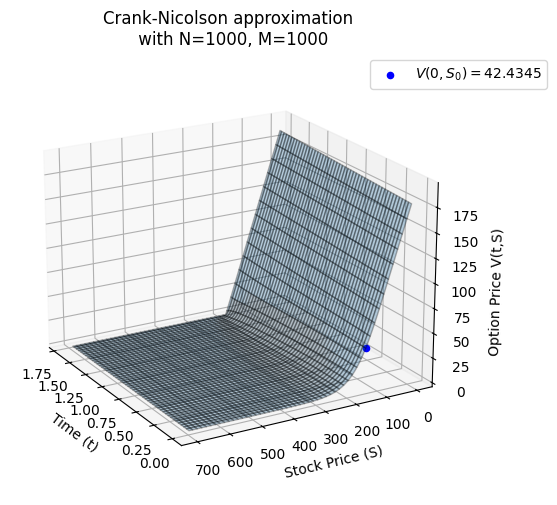

In [120]:
"""Output for the Crank-Nicolson method"""

S0=140.00
r=0.03
mu=0.13
gamma=0.99
T=1.7
N=1000
M=1000
K=186

print("Finite difference Approximation")
print("+++++++++++++++++++++++++")
V,t,S = price_put_crank_nicolson( K, T, r, sigmaFunc, gamma, N, M)
V_S0_t0 = np.interp(S0, S, V[0, :])
print("Crank Nicolson estimate of V(S_0,0): {}".format(V_S0_t0))
print("+++++++++++++++++++++++++")
h = S0 / 10000
delta_approx = (np.interp(S0 + h, S, V[0, :]) - np.interp(S0 - h, S, V[0, :])) / (2 * h)
print("Crank Nicolson estimate of delta: {}".format(delta_approx))
print("+++++++++++++++++++++++++")
plot_option_price(V,t,S)

In [121]:

"""V,t,S = price_put_crank_nicolson( K, T, r, sigmaFunc, gamma, 50000, 50000)
highresCN = np.interp(S0, S, V[0, :])"""

#Crank Nicolson approximation using a large grid size produced with code above
#Code not to be executed as it exceeds permitted runtime
highresCN=42.43653594011936

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import time


# Generate Monte Carlo and Crank-Nicholson data
# Larger amount of simulations run for the plot in report
# Number reduced here for purposes of runtime
MC_M = np.geomspace(100, 500000, 30)
MC_error = []
MC_times = []
for m in MC_M:
    start_MC = time.time()
    antithetic_option_sample = antithetic_samples(S0, r, mu, gamma, T, n_steps, int(m), CP, K)
    price, low, up = sample_analysis(antithetic_option_sample, 95)
    end_MC = time.time()
    MC_times.append(end_MC - start_MC)
    MC_error.append(abs(up - low))

CN_M = np.geomspace(20, 5000, 30)
CN_error = []
CN_times = []
for mCN in CN_M:
    start_CN = time.time()
    V, t, S = price_put_crank_nicolson(K, T, r, sigmaFunc, gamma, int(mCN), int(mCN))
    V_S0_t0 = np.interp(S0, S, V[0, :])
    end_CN = time.time()
    CN_times.append(end_CN - start_CN)
    CN_error.append(abs(highresCN - V_S0_t0))


MC_M = np.array(MC_M)
MC_times = np.array(MC_times)
MC_error = np.array(MC_error)
CN_M = np.array(CN_M)
CN_times = np.array(CN_times)
CN_error = np.array(CN_error)




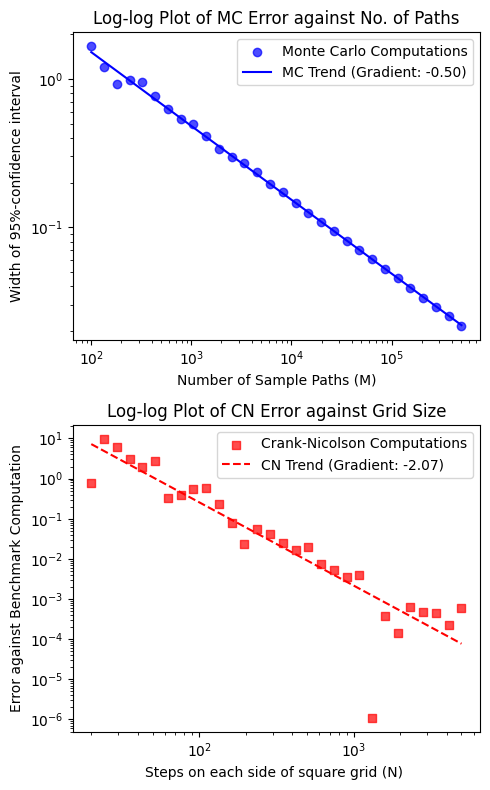

In [123]:
#log log regression lines
MC_slope_paths, MC_intercept_paths, _, _, _ = linregress(np.log(MC_M), np.log(MC_error))
CN_slope_grid, CN_intercept_grid, _, _, _ = linregress(np.log(CN_M), np.log(CN_error))
MC_trend_paths = np.exp(MC_intercept_paths) * MC_M**MC_slope_paths
CN_trend_grid = np.exp(CN_intercept_grid) * CN_M**CN_slope_grid

fig, axes = plt.subplots(2, 1, figsize=(5, 8))

#MC plot
axes[0].scatter(MC_M, MC_error, label="Monte Carlo Computations", color="blue", marker="o", alpha=0.7)
axes[0].loglog(MC_M, MC_trend_paths, linestyle="-", color="blue", label=f"MC Trend (Gradient: {MC_slope_paths:.2f})")
axes[0].set_xlabel("Number of Sample Paths (M)")
axes[0].set_ylabel("Width of 95%-confidence interval")
axes[0].set_title("Log-log Plot of MC Error against No. of Paths")
axes[0].legend()

#CN plot
axes[1].scatter(CN_M, CN_error, label="Crank-Nicolson Computations", color="red", marker="s", alpha=0.7)
axes[1].loglog(CN_M, CN_trend_grid, linestyle="--", color="red", label=f"CN Trend (Gradient: {CN_slope_grid:.2f})")
axes[1].set_xlabel("Steps on each side of square grid (N) ")
axes[1].set_ylabel("Error against Benchmark Computation")
axes[1].set_title("Log-log Plot of CN Error against Grid Size")
axes[1].legend()
plt.tight_layout()
plt.show()


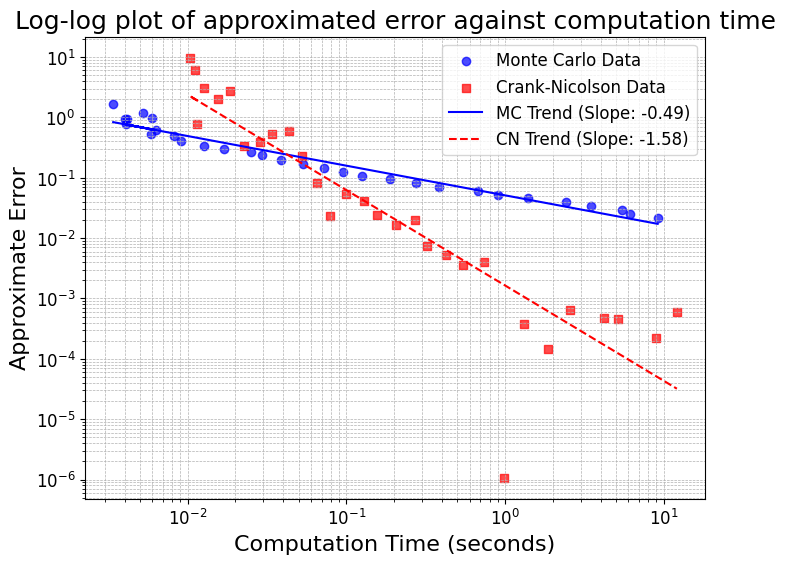

In [ ]:
#regression against computer time
MC_slope_time, MC_intercept_time, _, _, _ = linregress(np.log(MC_times), np.log(MC_error))
CN_slope_time, CN_intercept_time, _, _, _ = linregress(np.log(CN_times), np.log(CN_error))
MC_trend_time = np.exp(MC_intercept_time) * MC_times**MC_slope_time
CN_trend_time = np.exp(CN_intercept_time) * CN_times**CN_slope_time
#Data
plt.figure(figsize=(8, 6))
plt.scatter(MC_times, MC_error, label="Monte Carlo Data", color="blue", marker="o", alpha=0.7)
plt.scatter(CN_times, CN_error, label="Crank-Nicolson Data", color="red", marker="s", alpha=0.7)
# Trend lines plot
plt.loglog(MC_times, MC_trend_time, linestyle="-", color="blue", label=f"MC Trend (Slope: {MC_slope_time:.2f})")
plt.loglog(CN_times, CN_trend_time, linestyle="--", color="red", label=f"CN Trend (Slope: {CN_slope_time:.2f})")
plt.xlabel("Computation Time (seconds)", fontsize=16)
plt.ylabel("Approximate Error", fontsize=16)
plt.title("Log-log plot of approximated error against computation time", fontsize=18)
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
# Increase tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)ß

plt.show()